In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
# Importar os pacotes necessários
import os
import random
import cv2
import numpy as np
import xml.etree.ElementTree as ET

from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode


def get_glaucoma_dicts(img_dir):
    # Ler o diretório contendo as imagens e arquivos XML correspondentes
    dataset_dicts = []
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg"):
            record = {}
            image_path = os.path.join(img_dir, filename)
            record["file_name"] = image_path
            record["image_id"] = filename[:-4]
            height, width, channels = cv2.imread(image_path).shape
            record["height"] = height
            record["width"] = width
            
            xml_path = os.path.join(img_dir, filename[:-4] + ".xml")
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            objs = []
            for obj in root.findall('object'):
                name = obj.find('name').text
                if name == "disco":
                    bbox = obj.find('bndbox')
                    x_min = float(bbox.find('xmin').text)
                    y_min = float(bbox.find('ymin').text)
                    x_max = float(bbox.find('xmax').text)
                    y_max = float(bbox.find('ymax').text)
                    
                    obj = {
                        "bbox": [x_min, y_min, x_max, y_max],
                        "bbox_mode": BoxMode.XYXY_ABS,
                        "category_id": 0,
                    }
                    objs.append(obj)
            record["annotations"] = objs
            
            dataset_dicts.append(record)
    return dataset_dicts

# Registrar o dataset e definir os metadados



train_img_dir = "/content/drive/MyDrive/ProjetoGlaucoma/train" 
DatasetCatalog.register("glaucoma_train", lambda: get_glaucoma_dicts(train_img_dir))


# registre as informações da classe
MetadataCatalog.get("glaucoma_train").set(thing_classes=["disco"])




namespace(name='glaucoma_train', thing_classes=['disco'])

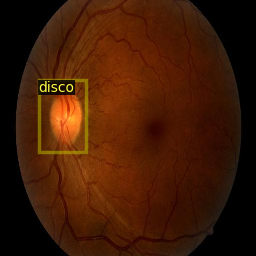

In [ ]:
glaucoma_metadata = MetadataCatalog.get("glaucoma_train")
glaucoma_dataset = DatasetCatalog.get("glaucoma_train")
for d in random.sample(glaucoma_dataset, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=glaucoma_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])
   

In [ ]:
def get_glaucoma_val_dicts(img_dir):
    # Ler o diretório contendo as imagens sem anotações
    dataset_dicts = []
    for filename in os.listdir(img_dir):
        if filename.endswith(".jpg"):
            record = {}
            image_path = os.path.join(img_dir, filename)
            record["file_name"] = image_path
            record["image_id"] = filename[:-4]
            height, width, channels = cv2.imread(image_path).shape
            record["height"] = height
            record["width"] = width
            
            record["annotations"] = []
            
            dataset_dicts.append(record)
    return dataset_dicts


In [ ]:
val_img_dir = "/content/drive/MyDrive/ProjetoGlaucoma/DataSet"

DatasetCatalog.register("glaucoma_val3", lambda: get_glaucoma_val_dicts(val_img_dir))

MetadataCatalog.get("glaucoma_val3").set(thing_classes=["disco"])

namespace(name='glaucoma_val3', thing_classes=['disco'])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("glaucoma_train",)
cfg.DATASETS.TEST = ("glaucoma_val3",) 
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4096   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # update number of classes
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ProjetoGlaucoma/TreinamentoSegmentacao" # set output directory

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


In [ ]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/ProjetoGlaucoma/TreinamentoSegmentacao/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


[05/06 14:45:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ProjetoGlaucoma/TreinamentoSegmentacao/model_final.pth ...


In [ ]:

img_paths = [os.path.join("/content/drive/MyDrive/ProjetoGlaucoma/DataSet", f) for f in os.listdir("/content/drive/MyDrive/ProjetoGlaucoma/DataSet") if f.endswith('.jpg')]

In [ ]:
#original  detecção de objetos e marcação das imagens
for img_path in img_paths:
    img = cv2.imread(img_path)
    outputs = predictor(img)
    v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes
    scores = instances.scores
    class_ids = instances.pred_classes
    num_instances = len(boxes)
    for i in range(num_instances):
        bbox = boxes.tensor[i].numpy()
        score = scores[i].numpy().item()
        class_id = class_ids[i].numpy()
        v.draw_box(bbox, edge_color='red', alpha=score)

         # cria uma pasta "anotacoes" se ela não existir ainda
        output_dir = os.path.join(os.path.dirname(img_path), "segmentadas")
        os.makedirs(output_dir, exist_ok=True)

         # adiciona o recorte da caixa delimitadora em uma nova variável
        x1, y1, x2, y2 = map(int, bbox)
        cropped_img = img[y1:y2, x1:x2]
        cropped_img = cv2.resize(cropped_img, (390, 390))

        # salva a imagem recortada com a marcação em um novo arquivo
        output_crop_path = os.path.join(output_dir,os.path.basename(img_path))
        cv2.imwrite(output_crop_path, cropped_img)



    out_img = v.get_output().get_image()
    out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
    output_path = os.path.join(os.path.dirname(img_path), os.path.basename(img_path))
   # cv2.imwrite(output_path, out_img, [cv2.IMWRITE_PNG_COMPRESSION, 0])
print("Todas as imagens foram recortadas e salvas com sucesso!")

Todas as imagens foram recortadas e salvas com sucesso!
